In [1]:
import librosa
import librosa.display
import soundfile as sf
import IPython.display
import numpy as np
import pandas as pd
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import vgg16
from keras.models import Model
import keras
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class AudioIdentifier:
    
    
    def __init__(self, prediction_model_path=None):
        self.vgg_model = self.load_vgg_model()
        self.prediction_model = self.load_prediction_model(prediction_model_path)
        self.class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', 
                          '3' : 'dog_bark', '4' : 'drilling', '5' : 'engine_idling', '6' : 'gun_shot', 
                          '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
        self.predicted_class = None
        self.predicted_label = None
        
    
    def load_vgg_model(self):
        vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=(64, 64, 3))
        output = vgg.layers[-1].output
        output = keras.layers.Flatten()(output)
        model = Model(vgg.input, output)
        model.trainable = False
        return model
    
    
    def load_prediction_model(self, model_path):
        pred_model = keras.models.load_model(model_path)
        return pred_model
    
        
    def get_sound_data(self, path, sr=22050):
        data, fsr = sf.read(path)
        data_22k = librosa.resample(y=data.T, orig_sr=fsr, target_sr=sr)
        if len(data_22k.shape) > 1:
            data_22k = np.average(data_22k, axis=0)
            
        return data_22k, sr
    
    
    def windows(self, data, window_size):
        start = 0
        while start < len(data):
            yield int(start), int(start + window_size)
            start += (window_size / 2) 
            
            
    def extract_base_features(self, sound_data, bands=64, frames=64):
        window_size = 512 * (frames - 1)  # 添加 window_size 定义
        log_specgrams_full = []
        log_specgrams_hp = []
    
        # 添加 windows 方法的调用
        windows = list(self.windows(sound_data, window_size))
        if not windows:
            raise ValueError("No valid windows found in sound_data")
    
        start, end = windows[0]
    
        signal = sound_data[start:end]
        
        # 添加缺失的 melspec_full 计算
        melspec_full = librosa.feature.melspectrogram(y=signal, sr=22050, n_mels=bands)
        logspec_full = librosa.amplitude_to_db(melspec_full)
        logspec_full = logspec_full.T.flatten()[:, np.newaxis].T
        
        # 添加缺失的 harmonic 和 percussive 分离
        y_harmonic, y_percussive = librosa.effects.hpss(signal)
        melspec_harmonic = librosa.feature.melspectrogram(y=y_harmonic, sr=22050, n_mels=bands)
        melspec_percussive = librosa.feature.melspectrogram(y=y_percussive, sr=22050, n_mels=bands)
        logspec_harmonic = librosa.amplitude_to_db(melspec_harmonic)
        logspec_percussive = librosa.amplitude_to_db(melspec_percussive)
        
        logspec_harmonic = logspec_harmonic.T.flatten()[:, np.newaxis].T
        logspec_percussive = logspec_percussive.T.flatten()[:, np.newaxis].T
        logspec_hp = np.average([logspec_harmonic, logspec_percussive], axis=0)

        log_specgrams_full.append(logspec_full)
        log_specgrams_hp.append(logspec_hp)
        
        if not log_specgrams_full or not log_specgrams_hp:
            raise ValueError("No valid spectrograms found in sound_data")
        log_specgrams_full = np.asarray(log_specgrams_full).reshape(len(log_specgrams_full), bands, frames, 1)
        log_specgrams_hp = np.asarray(log_specgrams_hp).reshape(len(log_specgrams_hp), bands, frames, 1)
        features = np.concatenate((log_specgrams_full, log_specgrams_hp, np.zeros(np.shape(log_specgrams_full))), axis=3)

        for i in range(len(features)):
            features[i, :, :, 2] = librosa.feature.delta(features[i, :, :, 0])

        return np.array(features)
    
    
    def extract_transfer_learn_features(self, base_feature_data):
        
        base_feature_data = np.expand_dims(base_feature_data, axis=0)
        base_feature_data = preprocess_input(base_feature_data)
        model = self.vgg_model
        tl_features = model.predict(base_feature_data)
        tl_features = np.reshape(tl_features, tl_features.shape[1])
        return tl_features
    
    
    def feature_engineering(self, audio_data):
        base_features = self.extract_base_features(sound_data=audio_data)
        final_feature_map = self.extract_transfer_learn_features(base_features[0])
        return final_feature_map
    
    def prediction(self, feature_map):
        """预测音频类别
        Args:
            feature_map: 特征图,numpy数组
        Returns:
            tuple: (predicted_class, confidence) 预测类别和置信度
        """
        try:
            # 输入验证
            if feature_map is None:
                raise ValueError("特征图不能为空")
            
            if not isinstance(feature_map, np.ndarray):
                feature_map = np.array(feature_map)
            
            # 确保特征图具有正确的维度
            if feature_map.ndim == 1:
                feature_map = feature_map.reshape(1, -1)
            elif feature_map.ndim > 2:
                raise ValueError(f"特征图维度过高: {feature_map.ndim}")
            
            # 使用正确的模型属性名
            predictions = self.prediction_model.predict(feature_map)
            predicted_class = np.argmax(predictions, axis=1)[0]
            confidence = np.max(predictions, axis=1)[0]
        
            return predicted_class, confidence
            
        except Exception as e:
            print(f"预测失败: {str(e)}")
            return None, None  # 明确返回 None 值

    
        
    
    def prediction_pipeline(self, audio_file_path, return_class_label=True):
        """预测管道
        Args:
            audio_file_path: 音频文件路径
            return_class_label: 是否返回标签文本
        Returns:
            str or int: 预测标签或类别
        """
        try:
            audio_data, sr = self.get_sound_data(audio_file_path)

            feature_map = self.feature_engineering(audio_data)

            prediction_class, confidence = self.prediction(feature_map)

            if prediction_class is None:
                raise ValueError("预测失败")
                
            self.predicted_class = prediction_class
            self.predicted_label = self.class_map[str(self.predicted_class)]
            
            if return_class_label:
                return self.predicted_label
            return self.predicted_class
        
        except Exception as e:
            print(f"预测管道执行失败: {str(e)}")
            return None

In [3]:
ai = AudioIdentifier(prediction_model_path='sound_classification_model.h5')

In [5]:
siren_path = 'D:/ustcCS2024/keshe/UrbanSound8K/audio/fold1/21684-9-0-30.wav'
gunshot_path = 'D:/ustcCS2024/keshe/UrbanSound8K/audio/fold1/46654-6-0-0.wav'
dogbark_path = 'D:/ustcCS2024/keshe/UrbanSound8K/audio/fold1/7383-3-0-0.wav'

In [ ]:
import os


In [6]:
siren_audio, siren_sr = ai.get_sound_data(siren_path)
gunshot_audio, gunshot_sr = ai.get_sound_data(gunshot_path)
dogbark_audio, dogbark_sr = ai.get_sound_data(dogbark_path)

In [7]:
actual_sounds = ['siren', 'gun_shot', 'dog_bark']
sound_data = [siren_audio, gunshot_audio, dogbark_audio]
sound_rate = [siren_sr, gunshot_sr, dogbark_sr]
sound_paths = [siren_path, gunshot_path, dogbark_path]

In [84]:
for sound_class, data, sr in zip(actual_sounds, sound_data, sound_rate):
    print(sound_class, ':')
    IPython.display.display(IPython.display.Audio(data=data, rate=sr))

siren :


gun_shot :


dog_bark :


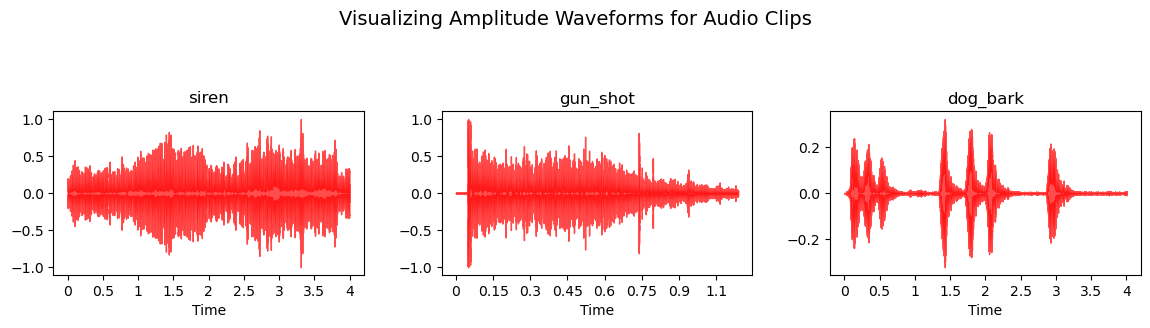

In [85]:
i = 1
fig = plt.figure(figsize=(12, 3.5))
t = plt.suptitle('Visualizing Amplitude Waveforms for Audio Clips', fontsize=14)
fig.subplots_adjust(top=0.8, wspace=0.2)

for sound_class, data, sr in zip(actual_sounds, sound_data, sound_rate):
    plt.subplot(1, 3, i)
    librosa.display.waveshow(data, sr=sr, color='r', alpha=0.7)
    plt.title(sound_class)
    i += 1
plt.tight_layout(pad=2.5)

In [8]:
siren_feature_map = ai.extract_base_features(siren_audio)[0]
#gunshot_feature_map = ai.extract_base_features(gunshot_audio)[0]
dogbark_feature_map = ai.extract_base_features(dogbark_audio)[0]
feature_maps = [siren_feature_map, dogbark_feature_map]

In [ ]:
# test

audio_data, sr = ai.get_sound_data(siren_path)

feature_map = ai.feature_engineering(audio_data)
feature_map = feature_map.reshape(1, -1)
print(feature_map)
print(feature_map.shape)
predictions = ai.prediction_model.predict(feature_map)
print(predictions)

1/1 [==============================] - 0s 34ms/step
[[0.        0.        0.        ... 0.        0.        2.3918564]]
(1, 2048)
1/1 [==============================] - 0s 26ms/step


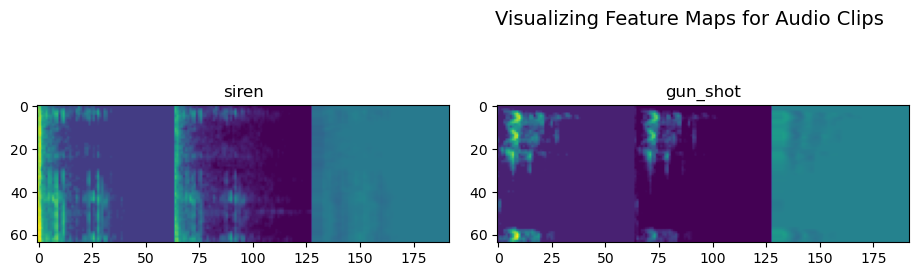

In [87]:
plt.figure(figsize=(14, 3))
t = plt.suptitle('Visualizing Feature Maps for Audio Clips', fontsize=14)
fig.subplots_adjust(top=0.8, wspace=0.1)
for index, (feature_map, category) in enumerate(zip(feature_maps, actual_sounds)):
    plt.subplot(1, 3, index+1)
    plt.imshow(np.concatenate((feature_map[:,:,0], feature_map[:,:,1], feature_map[:,:,2]), axis=1), cmap='viridis')
    plt.title(category)
plt.tight_layout(pad=1.5)

In [ ]:
ai.prediction_pipeline(siren_path,  return_class_label=True)

In [88]:
predictions = [ai.prediction_pipeline(audiofile_path, 
                                      return_class_label=True) 
                   for audiofile_path in sound_paths]

1/1 [==============================] - 0s 90ms/step
预测管道执行失败: cannot reshape array of size 3200 into shape (1,64,64,1)
1/1 [==============================] - 0s 28ms/step


In [90]:
result_df = pd.DataFrame({'Actual Sound': actual_sounds,
                          'Predicted Sound': predictions,
                          'Location': sound_paths})
result_df

,Actual Sound,Predicted Sound,Location
0,siren,street_music,D:/ustcCS2024/keshe/UrbanSound8K/audio/fold1/2...
1,gun_shot,None,D:/ustcCS2024/keshe/UrbanSound8K/audio/fold1/4...
2,dog_bark,dog_bark,D:/ustcCS2024/keshe/UrbanSound8K/audio/fold1/7...
